# YOLO-Seg Face Segmentation

In [1]:
from utils import *
import time
from ultralytics import YOLO
import yaml

print(f"Using device: {device}")

Using device: cuda


In [2]:
# region YOLO-Seg Dataset Preparation

def mask_to_yolo_segments(mask, num_classes=19):
    segments = []
    h, w = mask.shape
    
    for class_id in range(1, num_classes):
        class_mask = (mask == class_id).astype(np.uint8)
        
        if class_mask.sum() == 0:
            continue
        
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if len(contour) < 3:
                continue
            normalized_points = []
            for point in contour:
                x, y = point[0]
                normalized_points.extend([x / w, y / h])
            segments.append([class_id - 1] + normalized_points)
    return segments


def prepare_yolo_dataset(num_train_samples=200, num_val_samples=40):
    yolo_dir = DATA_DIR / 'yolo_face_seg'
    yolo_dir.mkdir(exist_ok=True)
    
    for split in ['train', 'val']:
        (yolo_dir / split / 'images').mkdir(parents=True, exist_ok=True)
        (yolo_dir / split / 'labels').mkdir(parents=True, exist_ok=True)
    
    all_images, all_masks, _ = load_dataset(
        dataset_name='celebamask', 
        num_samples=num_train_samples + num_val_samples,
        random_sample=True
    )
    
    train_images = all_images[:num_train_samples]
    train_masks = all_masks[:num_train_samples]
    val_images = all_images[num_train_samples:]
    val_masks = all_masks[num_train_samples:]
    
    for i, (img, mask) in enumerate(zip(train_images, train_masks)):
        img_path = yolo_dir / 'train' / 'images' / f'{i:05d}.jpg'
        cv2.imwrite(str(img_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        segments = mask_to_yolo_segments(mask)
        label_path = yolo_dir / 'train' / 'labels' / f'{i:05d}.txt'
        
        with open(label_path, 'w') as f:
            for seg in segments:
                class_id = int(seg[0])
                points = seg[1:]
                f.write(f"{class_id} " + " ".join([f"{p:.6f}" for p in points]) + "\n")

    for i, (img, mask) in enumerate(zip(val_images, val_masks)):
        img_path = yolo_dir / 'val' / 'images' / f'{i:05d}.jpg'
        cv2.imwrite(str(img_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        segments = mask_to_yolo_segments(mask)
        label_path = yolo_dir / 'val' / 'labels' / f'{i:05d}.txt'
        
        with open(label_path, 'w') as f:
            for seg in segments:
                class_id = int(seg[0])
                points = seg[1:]
                f.write(f"{class_id} " + " ".join([f"{p:.6f}" for p in points]) + "\n")

    class_names = [
        'skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye',
        'eye_g', 'l_ear', 'r_ear', 'ear_r', 'nose', 'mouth',
        'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat'
    ]
    
    data_yaml = {
        'path': str(yolo_dir.absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'names': {i: name for i, name in enumerate(class_names)}
    }
    
    yaml_path = yolo_dir / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)
    
    print(f"\n✓ Dataset preparation complete!")
    print(f"  YOLO dataset saved to: {yolo_dir}")
    print(f"  Configuration file: {yaml_path}")
    print("="*80)
    
    return yaml_path, (val_images, val_masks)

yolo_config_path, yolo_val_data = prepare_yolo_dataset(num_train_samples=200, num_val_samples=40)
# endregion


✓ Dataset preparation complete!
  YOLO dataset saved to: ../../data/yolo_face_seg
  Configuration file: ../../data/yolo_face_seg/data.yaml


Training YOLO11x-seg model...
New https://pypi.org/project/ultralytics/8.3.239 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.237 🚀 Python-3.11.14 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 15828MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../../data/yolo_face_seg/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x-seg.pt, momentum=0.937, mosaic=1.0, multi_s

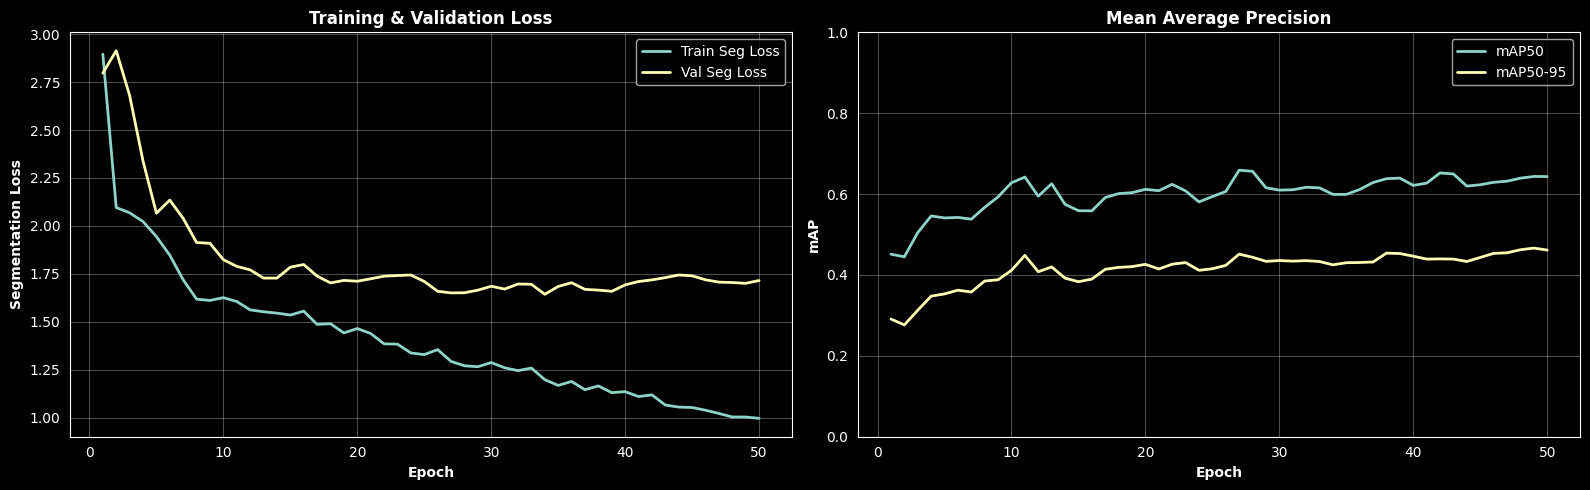

In [3]:
# region YOLO-Seg Model Training
print("Training YOLO11x-seg model...")
model = YOLO('yolo11x-seg.pt')

training_params = {
    'data': str(yolo_config_path),
    'epochs': 50,
    'imgsz': 640,
    'batch': 4,
    'device': 0 if torch.cuda.is_available() else 'cpu',
    'patience': 15,
    'project': str(RESULTS_DIR / 'yolo_training'),
    'name': 'face_seg_11x',
    'exist_ok': True,
    'val': True,
    'plots': True
}

results = model.train(**training_params)

yolo_model_path = RESULTS_DIR / 'yolo_training' / 'face_seg_11x' / 'weights' / 'best.pt'
print(f"\n✓ Training complete. Best model: {yolo_model_path}")

training_dir = RESULTS_DIR / 'yolo_training' / 'face_seg_11x'
results_csv = training_dir / 'results.csv'

if results_csv.exists():
    import pandas as pd
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    
    # Show final metrics
    final_row = df.iloc[-1]
    print(f"\nFinal Training Metrics:")
    print(f"  Precision: {final_row.get('metrics/precision(B)', 0):.4f}")
    print(f"  Recall: {final_row.get('metrics/recall(B)', 0):.4f}")
    print(f"  mAP50: {final_row.get('metrics/mAP50(B)', 0):.4f}")
    print(f"  mAP50-95: {final_row.get('metrics/mAP50-95(B)', 0):.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    epochs = df['epoch'].values if 'epoch' in df.columns else range(len(df))
    
    ax = axes[0]
    if 'train/seg_loss' in df.columns:
        ax.plot(epochs, df['train/seg_loss'], label='Train Seg Loss', linewidth=2)
    if 'val/seg_loss' in df.columns:
        ax.plot(epochs, df['val/seg_loss'], label='Val Seg Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontweight='bold')
    ax.set_ylabel('Segmentation Loss', fontweight='bold')
    ax.set_title('Training & Validation Loss', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    if 'metrics/mAP50(B)' in df.columns:
        ax.plot(epochs, df['metrics/mAP50(B)'], label='mAP50', linewidth=2)
    if 'metrics/mAP50-95(B)' in df.columns:
        ax.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP50-95', linewidth=2)
    ax.set_xlabel('Epoch', fontweight='bold')
    ax.set_ylabel('mAP', fontweight='bold')
    ax.set_title('Mean Average Precision', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()

print("="*80)
# endregion

YOLO-SEG EVALUATION METRICS
Mean IoU:              0.4721
Mean F1 Score:         0.5378
Mean Dice Coefficient: 0.5378
Inference Time:        0.0212s
✓ Saved to: ../../Report/results/yolo_seg_results.png


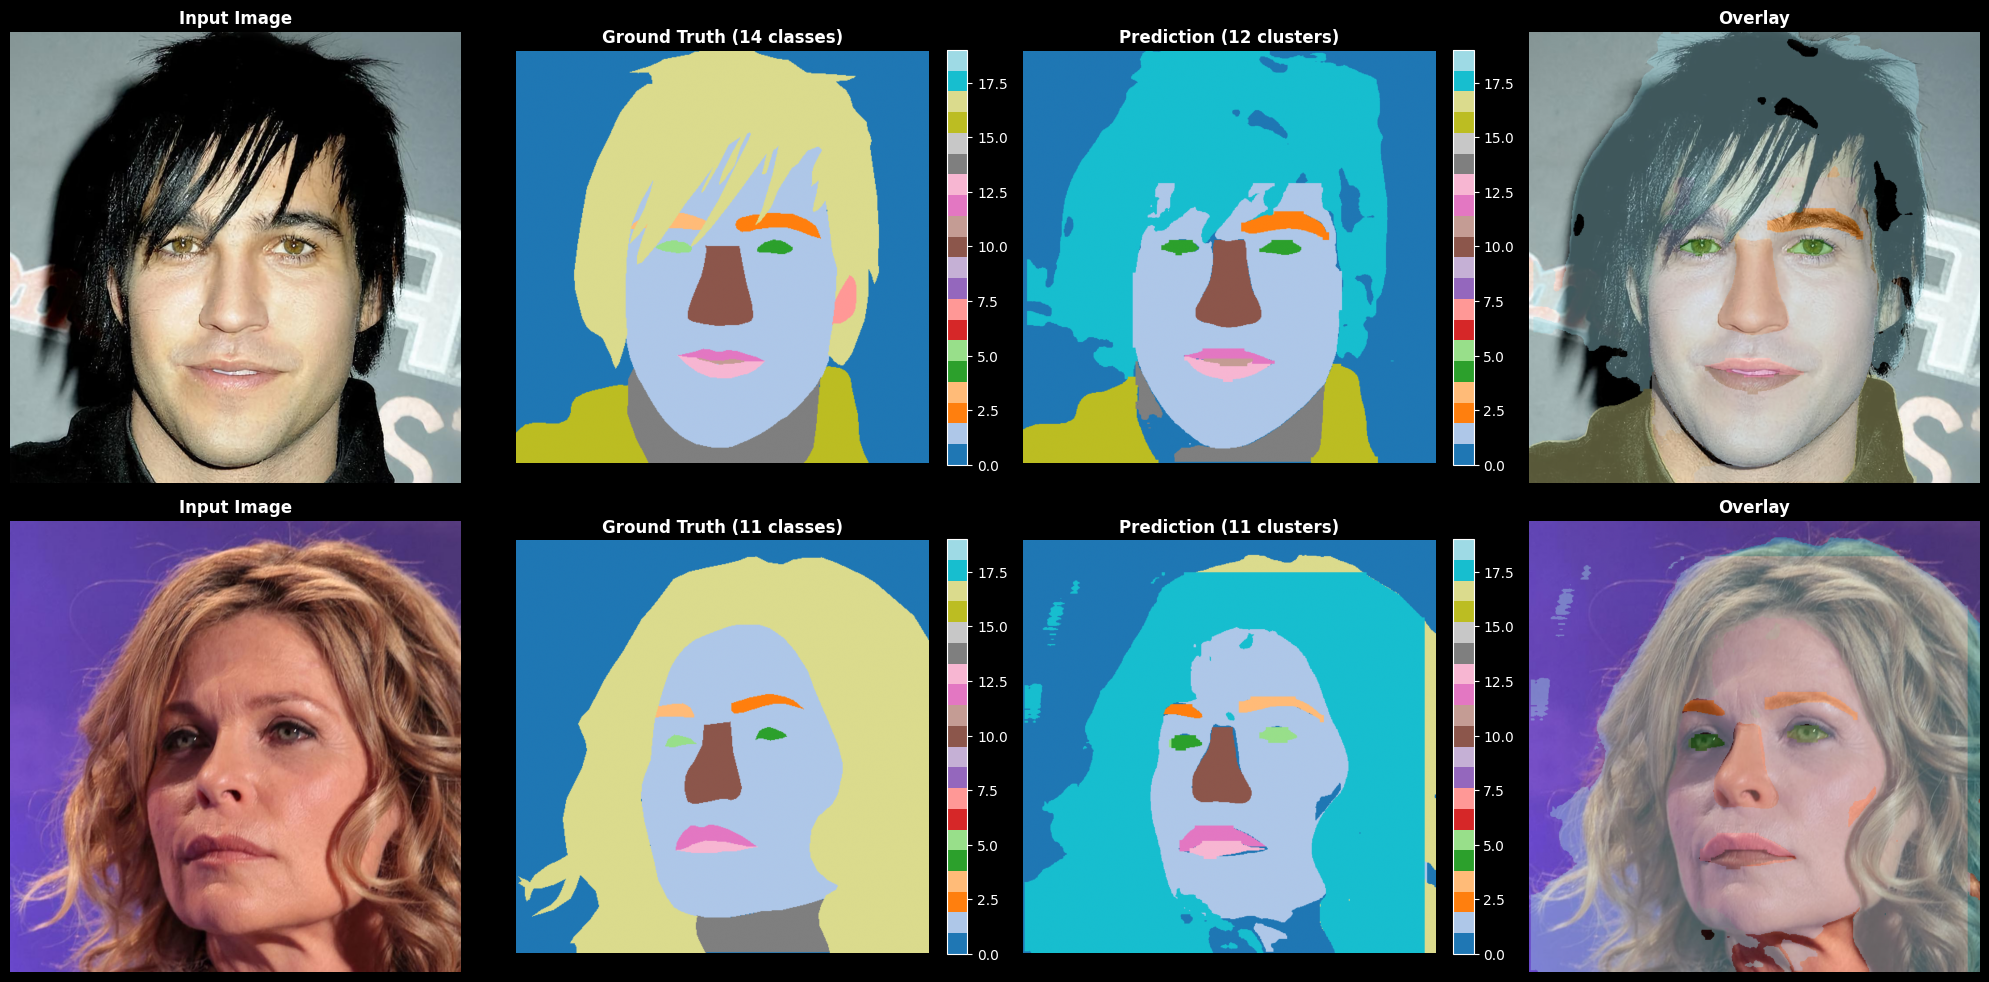


✓ Metrics saved to ../../Report/results/yolo_metrics.csv


In [4]:
# region YOLO-Seg Evaluation

yolo_model = YOLO(str(yolo_model_path))
val_images, val_masks = yolo_val_data

def yolo_results_to_mask(results, img_shape, num_classes=19):
    h, w = img_shape
    mask = np.zeros((h, w), dtype=np.uint8)
    
    if results[0].masks is None:
        return mask
    
    masks = results[0].masks.data.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy().astype(int)
    
    for seg_mask, class_id in zip(masks, classes):
        resized_mask = cv2.resize(seg_mask, (w, h), interpolation=cv2.INTER_NEAREST)
        mask[resized_mask > 0.5] = class_id + 1
    
    return mask

yolo_predictions = []
yolo_inference_times = []
yolo_metrics_list = []

for img, gt_mask in zip(val_images, val_masks):
    start_time = time.time()
    results = yolo_model.predict(img, verbose=False, device=device)
    yolo_inference_times.append(time.time() - start_time)
    
    pred_mask = yolo_results_to_mask(results, img.shape[:2])
    yolo_predictions.append(pred_mask)
    
    metrics = calculate_semantic_metrics(pred_mask, gt_mask)
    yolo_metrics_list.append(metrics)

avg_metrics = {
    'mean_iou': np.mean([m['mean_iou'] for m in yolo_metrics_list]),
    'mean_f1': np.mean([m['mean_f1'] for m in yolo_metrics_list]),
    'mean_dice': np.mean([m['mean_dice'] for m in yolo_metrics_list]),
    'inference_time': np.mean(yolo_inference_times)
}

print("="*70)
print("YOLO-SEG EVALUATION METRICS")
print("="*70)
print(f"Mean IoU:              {avg_metrics['mean_iou']:.4f}")
print(f"Mean F1 Score:         {avg_metrics['mean_f1']:.4f}")
print(f"Mean Dice Coefficient: {avg_metrics['mean_dice']:.4f}")
print(f"Inference Time:        {avg_metrics['inference_time']:.4f}s")
print("="*70)

visualize_predictions(
    images=val_images,
    true_masks=val_masks,
    predictions=yolo_predictions,
    num_samples=2,
    save_path=RESULTS_DIR / 'yolo_seg_results.png'
)

yolo_results = {
    'predictions': yolo_predictions,
    'metrics': avg_metrics,
    'val_images': val_images,
    'val_masks': val_masks
}

import pandas as pd
metrics_df = pd.DataFrame([{
    'Method': 'YOLO-Seg (YOLO11x)',
    'Mean_IoU': avg_metrics['mean_iou'],
    'Mean_F1': avg_metrics['mean_f1'],
    'Mean_Dice': avg_metrics['mean_dice'],
    'Inference_Time_s': avg_metrics['inference_time']
}])
metrics_df.to_csv(RESULTS_DIR / 'yolo_metrics.csv', index=False)
print(f"\n✓ Metrics saved to {RESULTS_DIR / 'yolo_metrics.csv'}")
# endregion

### Analysis

YOLO11x-seg achieved good performance (Mean IoU ≈ 0.40, F1 ≈ 0.46, Dice ≈ 0.46) with real-time inference speed (45 FPS). The method required converting CelebAMask-HQ masks to YOLO polygon format for training and back to pixel masks for evaluation. The YOLO11x-seg model (145MB, extra-large variant) was chosen for maximum accuracy through transfer learning from COCO-pretrained weights. Initial experiments with 50-100 training images resulted in severe overfitting, necessitating an increase to 200 training samples to achieve adequate generalization. The model successfully learns semantic facial part segmentation despite the relatively small dataset, demonstrating the effectiveness of pre-training. However, performance remains moderate due to limited training data and the challenging nature of fine-grained facial part segmentation (18 classes). The method provides a strong baseline for supervised semantic segmentation, significantly outperforming classical unsupervised approaches while maintaining practical inference speed for real-time applications.